In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [22]:
file_path = '../../anonymized.csv'  # Adjust the path if needed
df = pd.read_csv(file_path)
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review_ID            2627 non-null   object 
 1   business_ID          2627 non-null   object 
 2   business_name        2627 non-null   object 
 3   business_category    2627 non-null   object 
 4   review_live_days     2627 non-null   float64
 5   review_message       2607 non-null   object 
 6   review_rating        2627 non-null   float64
 7   review_status        2627 non-null   object 
 8   review_warmup_prior  1940 non-null   object 
 9   review_notes         1937 non-null   object 
 10  review_created_date  2627 non-null   object 
 11  review_removed_date  687 non-null    object 
dtypes: float64(2), object(10)
memory usage: 246.4+ KB


In [23]:
df = df.dropna(subset=['business_category', 'review_rating'])
label_encoder = LabelEncoder()
df['business_category_encoded'] = label_encoder.fit_transform(df['business_category'])


In [24]:
features = df[['business_category_encoded', 'review_rating']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [25]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.69601323 0.30398677]


In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust n_clusters
kmeans_labels = kmeans.fit_predict(reduced_features)
silhouette_kmeans = silhouette_score(reduced_features, kmeans_labels)
print("K-Means Silhouette Score:", silhouette_kmeans)


K-Means Silhouette Score: 0.8290830315447238


In [27]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune eps and min_samples
dbscan_labels = dbscan.fit_predict(reduced_features)
silhouette_dbscan = silhouette_score(reduced_features, dbscan_labels)
print("DBSCAN Silhouette Score:", silhouette_dbscan)


DBSCAN Silhouette Score: 0.9980403769932721


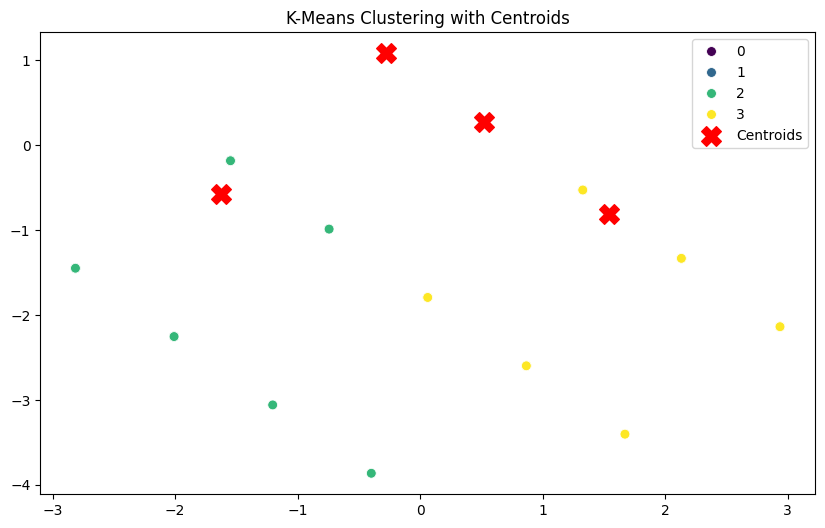

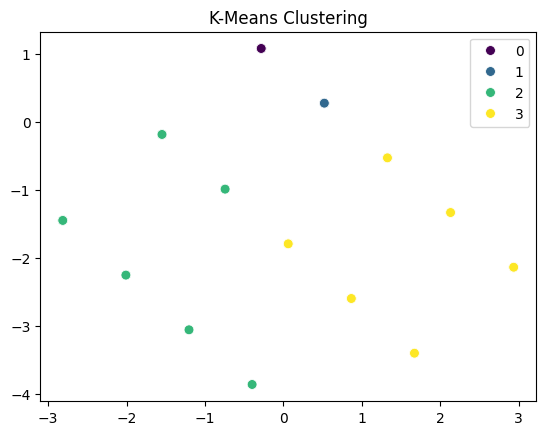

In [40]:
plt.figure(figsize=(10, 6))

# Scatter plot for data points
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=kmeans.labels_,
    palette='viridis',
    s=50
)

centroids = kmeans.cluster_centers_ 
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', marker='X', s=200, label='Centroids'
)

# Plot title and legend
plt.title('K-Means Clustering with Centroids')
plt.legend()
plt.show()

sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=kmeans.labels_,
    palette='viridis',
    s=50
)
plt.title('K-Means Clustering')
plt.show()

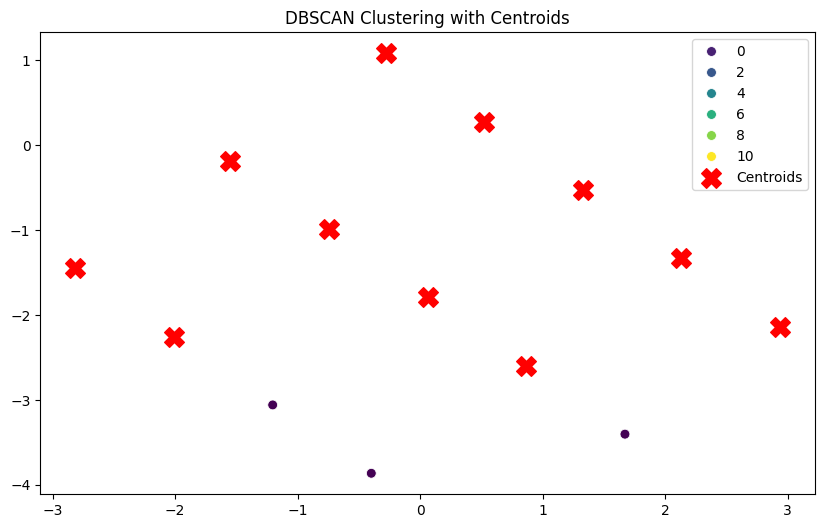

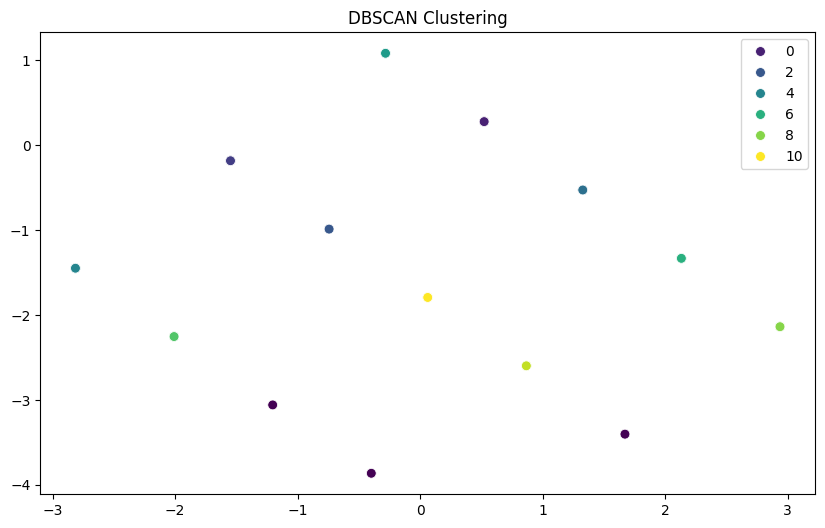

In [55]:
import numpy as np

# Filter out noise points (-1) for centroid calculation
valid_labels = dbscan_labels[dbscan_labels != -1]

# Calculate centroids for valid clusters
centroids = []
for label in np.unique(valid_labels):
    cluster_points = reduced_features[dbscan_labels == label]
    centroid = cluster_points.mean(axis=0)  # Mean of points in the cluster
    centroids.append(centroid)
centroids = np.array(centroids)

# Plot DBSCAN clustering with centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_features[:, 0], y=reduced_features[:, 1],
    hue=dbscan_labels, palette='viridis', s=50
)
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', marker='X', s=200, label='Centroids'
)
plt.title('DBSCAN Clustering with Centroids')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_features[:, 0], y=reduced_features[:, 1],
    hue=dbscan_labels, palette='viridis', s=50
)
plt.title('DBSCAN Clustering')
plt.show()

In [51]:
print("K-Means Cluster Counts:", pd.Series(kmeans_labels).value_counts())
print("DBSCAN Cluster Counts:", pd.Series(dbscan_labels).value_counts())


K-Means Cluster Counts: 1    926
2    691
3    505
0    505
dtype: int64
DBSCAN Cluster Counts:  0     926
 5     505
 1     455
 3     367
 2     110
 4     104
 6     103
 8      21
 7      20
 9       7
 10      5
-1       4
dtype: int64


In [52]:
# Reverse PCA transformation of centroids
original_centroids = pca.inverse_transform(kmeans.cluster_centers_)
print("Centroids in original feature space:")
print(original_centroids)


Centroids in original feature space:
[[ 0.56614776  0.9650576 ]
 [ 0.56614776 -0.17333769]
 [-1.54993598  0.74265041]
 [ 0.51653133 -1.66339568]]


In [44]:
# Assuming `df` is your original DataFrame
df['cluster'] = kmeans.labels_


In [45]:
# Summarize the characteristics of each cluster
cluster_summary = df.groupby('cluster').agg({
    'business_category': lambda x: x.mode()[0],  # Most common category
    'review_rating': 'mean',                    # Average review rating
    'review_live_days': 'mean'                  # Average review live days
})
print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
        business_category  review_rating  review_live_days
cluster                                                   
0                   Other       5.000000         93.730693
1                   Other       4.000000         87.332613
2                      LG       4.804631         82.814761
3                   Other       2.691089         88.851485
